___

<a href='https://sites.google.com/fat.uerj.br/livia'> <img src='../../figures/capa2.png' /></a>
___

In [1]:
path_data = '../../data/'
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Causality

Nossos métodos para comparar duas amostras têm um uso poderoso na análise de experimentos controlados randomizados. Uma vez que os grupos de tratamento e controle são distribuídos aleatoriamente em tais experimentos, as diferenças em seus resultados podem ser comparadas ao que aconteceria apenas devido ao acaso se o tratamento não tivesse nenhum efeito. Se as diferenças observadas forem mais marcantes do que poderíamos prever como puramente devido ao acaso, teremos evidências de *causação*. Devido à atribuição imparcial de indivíduos aos grupos de tratamento e controle, as diferenças nos resultados dos dois grupos podem ser atribuídas ao tratamento.

A chave para a análise de experimentos controlados randomizados é entender exatamente como o acaso entra em cena. Isso nos ajuda a estabelecer hipóteses nulas e alternativas claras. Feito isso, podemos simplesmente usar os métodos das seções anteriores para concluir a análise.

Vamos ver como fazer isso em um exemplo.

In [3]:
bta = pd.read_csv(path_data + 'bta.csv')
bta

,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Control,0.0
5,Control,0.0
6,Control,0.0
7,Control,0.0
8,Control,0.0
9,Control,0.0


Vamos ver quantos pacientes se recuperaram em cada grupo. Lembre-se de que contar é o mesmo que somar zeros e uns. A soma de 1 no grupo de controle é o número de pacientes do grupo de controle que tiveram alívio da dor.

In [5]:
bta.groupby('Group').sum()

,Result
Group,
Control,2.0
Treatment,9.0


Como a contagem é igual à *soma* de zeros e uns, a *proporção* de pacientes que tiveram alívio da dor é a *média* de zeros e uns. É a soma dividida pelo número total de pacientes em cada grupo.

In [6]:
bta.groupby('Group').mean()

,Result
Group,
Control,0.125
Treatment,0.600


No grupo de tratamento, 60% dos pacientes tiveram alívio da dor, em comparação com apenas 12,5% no grupo controle. Nenhum dos pacientes sofreu efeitos colaterais.

Portanto, as indicações são de que a toxina botulínica A se saiu melhor do que a solução salina. Mas a conclusão ainda não é um slam-dunk. Os pacientes foram distribuídos aleatoriamente nos dois grupos, então talvez a diferença possa ser apenas devido ao acaso?

Para entender o que isso significa, temos que considerar a possibilidade de que entre os 31 pacientes do estudo, alguns simplesmente conseguiram se recuperar melhor do que outros, mesmo sem nenhuma ajuda do tratamento. E se uma proporção extraordinariamente grande desses pacientes fosse designada para o grupo de tratamento, apenas por acaso? Então, mesmo que o tratamento não fizesse nada além da solução salina no grupo de controle, os resultados do grupo de tratamento poderiam parecer melhores do que os do grupo de controle.

Para levar em conta essa possibilidade, vamos começar configurando cuidadosamente o modelo de chance.

## Resultados potenciais
Antes de os pacientes serem randomizados nos dois grupos, nossas mentes instintivamente imaginam dois resultados possíveis para cada paciente: o resultado que o paciente teria se fosse designado para o grupo de tratamento e o resultado que o mesmo paciente teria se fosse designado para o grupo de controle. . Estes são chamados de dois *resultados potenciais* do paciente.

Assim, existem 31 resultados potenciais de tratamento e 31 resultados potenciais de controle. A questão é sobre as distribuições desses dois conjuntos de 31 resultados cada. Eles são os mesmos, ou são diferentes?

Ainda não podemos responder, porque não conseguimos ver todos os 31 valores em cada grupo. Apenas conseguimos ver 16 resultados de controle em potencial selecionados aleatoriamente e os resultados do tratamento dos 15 pacientes *restantes*.

Aqui está uma boa maneira de visualizar a configuração. Cada paciente tem um bilhete de dois lados:

![Two-sided ticket](../../figures/causality1.png)

Após a randomização, conseguimos ver a metade direita de um conjunto de ingressos selecionados aleatoriamente e a metade esquerda do grupo restante.

![Half-tickets](../../figures/causality2.png)

A tabela 'resultados_observados' coleta as informações sobre os resultados potenciais de cada paciente, deixando a metade não observada de cada "bilhete" em branco. (É apenas outra maneira de pensar sobre a tabela `bta`, carregando a mesma informação.)

In [7]:
observed_outcomes = pd.read_csv(path_data + 'observed_outcomes.csv')
observed_outcomes

,Group,Outcome if assigned treatment,Outcome if assigned control
0,Control,Unknown,1
1,Control,Unknown,1
2,Control,Unknown,0
3,Control,Unknown,0
4,Control,Unknown,0
5,Control,Unknown,0
6,Control,Unknown,0
7,Control,Unknown,0
8,Control,Unknown,0
9,Control,Unknown,0


## As Hipóteses
A questão é se o tratamento faz alguma coisa. Em termos da tabela `resultados_observados`, a questão é se a distribuição dos 31 valores de "tratamento" na coluna 1 (incluindo os desconhecidos) é diferente da distribuição dos 31 valores de "controle" na coluna 2 (novamente incluindo o desconhecidos).

**Hipótese Nula:** A distribuição de todos os 31 resultados potenciais de "tratamento" é a mesma de todos os 31 resultados potenciais de "controle". A toxina botulínica A não faz nada diferente da solução salina; a diferença nas duas amostras é apenas devido ao acaso.

**Hipótese alternativa:** A distribuição de 31 possíveis resultados de "tratamento" é diferente daquela dos 31 resultados de controle. O tratamento faz algo diferente do controle.

Observe que a alternativa não está especificando que o tratamento ajuda – apenas que é diferente do controle. Isso é padrão em estudos médicos porque não pré-julga qual caminho o resultado pode seguir. Mas você pode fazer um teste para saber se o tratamento é melhor do que o controle. Basta ajustar sua estatística de teste de acordo.

Existem 31 resultados observados conjuntamente nos dois grupos. Se a hipótese nula fosse verdadeira, não importaria qual desses 31 resultados foi rotulado como "tratamento" e qual "controle". Qualquer subconjunto aleatório de 16 dos 31 valores pode ser chamado de "controle" e os 15 restantes de "tratamento".

Podemos simular isso. Podemos permutar aleatoriamente os 31 valores, dividi-los em dois grupos de 16 e 15 e ver como são diferentes as distribuições nos dois grupos. Como os dados são zeros e uns, podemos ver quão diferentes são as duas proporções.

Isso é exatamente o que fizemos para o teste A/B na seção anterior. A Amostra A é agora o grupo de controle e a Amostra B o grupo de tratamento. Faremos o teste abaixo mostrando os detalhes de todas as etapas. Você deve confirmar se eles são iguais aos passos realizados para o teste A/B.

## A estatística de teste
Se as duas proporções de grupo forem muito diferentes entre si, nos inclinaremos para a hipótese alternativa de que as duas distribuições subjacentes são diferentes. Assim, nossa estatística de teste será a distância entre as proporções dos dois grupos, ou seja, o valor absoluto da diferença entre eles.

Grandes valores da estatística de teste favorecerão a hipótese alternativa sobre a nula.

Como as proporções dos dois grupos foram 0,6 e 0,125, o valor observado da estatística de teste é $| 0,6 - 0,125 | = 0,475$.

In [8]:
bta.groupby('Group').mean()

,Result
Group,
Control,0.125
Treatment,0.600


In [11]:
observed_proportions = bta.groupby('Group').mean()['Result']
observed_distance = abs(observed_proportions[0] - observed_proportions[1])
observed_distance

0.475

Como fizemos antes, definiremos uma função que recebe os dois argumentos a seguir:

- o nome da tabela de dados
- o rótulo da coluna dos rótulos do grupo

e retorna a distância entre as duas proporções de grupo.

In [15]:
def distance(table, group_label):
    reduced = table.loc[:, ['Result', group_label]]
    proportions = reduced.groupby(group_label).mean()['Result']
    return abs(proportions[1] - proportions[0])

In [16]:
distance(bta, 'Group')

0.475

## Prevendo a estatística sob a hipótese nula
Podemos simular resultados sob a hipótese nula, para ver como nossa estatística de teste deve sair se a hipótese nula for verdadeira.

### Gerando um valor da estatística
A simulação segue exatamente o mesmo processo que usamos na seção anterior. Começamos permutando aleatoriamente todos os rótulos de grupo e, em seguida, anexando os rótulos embaralhados aos resultados 0/1.

In [30]:
shuffled_labels = bta.sample(replace=False, n=len(bta))['Group']
shuffled_labels

13      Control
19    Treatment
6       Control
10      Control
25    Treatment
28    Treatment
11      Control
27    Treatment
1       Control
16    Treatment
2       Control
20    Treatment
5       Control
14      Control
23    Treatment
29    Treatment
15      Control
18    Treatment
4       Control
12      Control
8       Control
0       Control
7       Control
30    Treatment
24    Treatment
3       Control
26    Treatment
17    Treatment
9       Control
21    Treatment
22    Treatment
Name: Group, dtype: object

In [37]:
shuffled_labels = bta.sample(replace=False, n=len(bta))['Group']
bta_with_shuffled_labels = bta.assign(Shuffled_Label=shuffled_labels.reset_index(drop=True))
bta_with_shuffled_labels

,Group,Result,Shuffled_Label
0,Control,1.0,Treatment
1,Control,1.0,Control
2,Control,0.0,Treatment
3,Control,0.0,Control
4,Control,0.0,Treatment
5,Control,0.0,Treatment
6,Control,0.0,Control
7,Control,0.0,Treatment
8,Control,0.0,Control
9,Control,0.0,Control


Agora podemos encontrar a distância entre as duas proporções depois que os rótulos dos grupos foram embaralhados.

In [38]:
distance(bta_with_shuffled_labels, 'Shuffled_Label')

0.08750000000000002

Isso é bem diferente da distância entre as duas proporções originais.

In [39]:
distance(bta_with_shuffled_labels, 'Group')

0.475

### Teste de Permutação
Se embaralharmos os rótulos novamente, quão diferente seria a nova distância? Para responder a isso, definiremos uma função que simula um valor simulado da distância sob a hipótese de sorteios aleatórios da mesma distribuição subjacente. E então coletaremos 20.000 desses valores simulados em uma matriz.

Você pode ver que estamos fazendo exatamente o que fizemos em nossos exemplos anteriores do teste de permutação.

In [40]:
def one_simulated_distance():
    shuffled_labels = bta.sample(replace=False, n=len(bta))['Group']
    shuffled_table = bta.assign(Shuffled_Label=shuffled_labels.reset_index(drop=True))
    return distance(shuffled_table, 'Shuffled_Label') 

In [14]:
def one_simulated_distance():
    shuffled_labels = bta.sample(with_replacement = False
                                                    ).column('Group')
    shuffled_table = bta.select('Result').with_column(
        'Shuffled Label', shuffled_labels)
    return distance(shuffled_table, 'Shuffled Label') 

In [41]:
distances = np.array([])

repetitions = 20000
for i in np.arange(repetitions):
    new_distance = one_simulated_distance()
    distances = np.append(distances, new_distance)

## Conclusão do Teste
A matriz `distances` contém 20.000 valores de nossa estatística de teste simulada sob a hipótese nula. Aqui está seu histograma empírico junto com o valor observado da estatística. Para encontrar o valor P do teste, lembre-se de que grandes valores de distância favorecem a hipótese alternativa.

In [49]:
observed_distance

0.475

Observed Distance 0.475


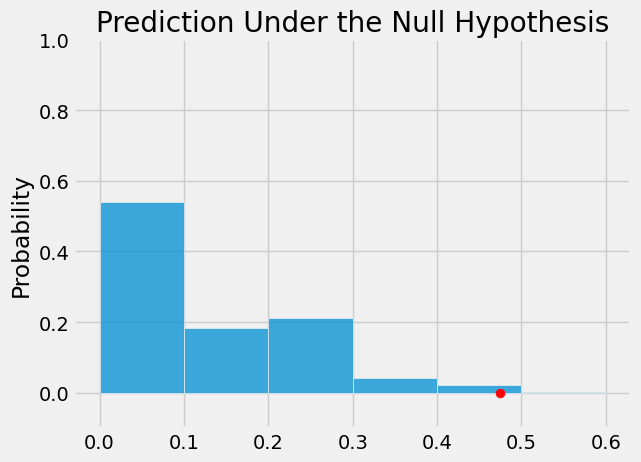

In [52]:
sns.histplot(distances, bins=np.arange(0, 0.7, 0.1), stat='probability')

plt.ylim(-0.1, 1)
plt.scatter(observed_distance, 0, color='red', s=40, zorder=3)
plt.title('Prediction Under the Null Hypothesis')
print('Observed Distance', observed_distance)

Para encontrar o valor-p empírico numericamente, devemos encontrar a proporção de estatísticas simuladas que foram iguais ou maiores que a estatística observada.

In [53]:
empirical_p = np.count_nonzero(distances >= observed_distance) / repetitions
empirical_p

0.0096

Este é um pequeno valor-p. A estatística observada está na cauda do histograma empírico da estatística de teste gerada sob a hipótese nula.

O resultado é estatisticamente significativo. O teste favorece a hipótese alternativa sobre a nula. A evidência apóia a hipótese de que o tratamento está fazendo alguma coisa.

O estudo relata um valor P de 0,009, ou 0,9%, que não está longe do nosso valor empírico.

## Causalidade
Como os ensaios foram randomizados, o teste é uma evidência de que o tratamento *causa* a diferença. A atribuição aleatória de pacientes aos dois grupos garante que não haja variável de confusão que possa afetar a conclusão da causalidade.

Se o tratamento não tivesse sido atribuído aleatoriamente, nosso teste ainda apontaria para uma *associação* entre o tratamento e os resultados de dor nas costas entre nossos 31 pacientes. Mas cuidado: sem a randomização, essa associação não implicaria que o tratamento causasse uma mudança nos desfechos de dor nas costas. Por exemplo, se os próprios pacientes tivessem escolhido administrar o tratamento, talvez os pacientes com mais dor estivessem mais propensos a escolher o tratamento *e* mais propensos a sentir alguma redução na dor, mesmo sem medicação. A dor pré-existente seria então um *fator de confusão* na análise.

## Uma meta-análise

Embora o RCT forneça evidências de que o tratamento com toxina botulínica A ajudou os pacientes, um estudo de 31 pacientes não é suficiente para estabelecer a eficácia de um tratamento médico. Isso não se deve apenas ao pequeno tamanho da amostra. Nossos resultados nesta seção são válidos para os 31 pacientes do estudo, mas estamos realmente interessados na população de *todos os possíveis pacientes*.

Em 2011, um grupo de pesquisadores realizou uma [metanálise](https://www.ncbi.nlm.nih.gov/pubmed/21249702) dos estudos sobre o tratamento. Ou seja, eles identificaram todos os estudos disponíveis de tais tratamentos para dor lombar e resumiram os resultados coligidos.

Houve vários estudos, mas muitos não puderam ser incluídos de maneira cientificamente sólida: "Excluímos evidências de dezenove estudos devido à não randomização, dados incompletos ou não publicados." Restaram apenas três ensaios clínicos randomizados, um dos quais é o que estudamos nesta seção. A meta-análise deu a ele a avaliação mais alta entre todos os estudos (LBP significa dor lombar): "Identificamos três estudos que investigaram os méritos da BoNT para lombalgia, mas apenas um teve um baixo risco de viés e avaliou pacientes com DL não específica (N = 31)."

Juntando tudo, a meta-análise concluiu: "Há evidências de baixa qualidade de que as injeções de BoNT melhoraram a dor, a função ou ambas melhor do que as injeções salinas e evidências de qualidade muito baixa de que foram melhores do que a acupuntura ou injeções de esteróides. ... é muito provável que a pesquisa tenha um impacto importante na estimativa do efeito e em nossa confiança nele. Estudos futuros devem padronizar populações de pacientes, protocolos de tratamento e grupos de comparação, recrutar mais participantes e incluir resultados de longo prazo, análise de custo-benefício e relevância clínica de descobertas".

É preciso muito trabalho cuidadoso para estabelecer que um tratamento médico tem um efeito benéfico. Saber como analisar ensaios clínicos randomizados é uma parte crucial deste trabalho. Agora que você sabe como fazer isso, está bem posicionado para ajudar médicos e outras profissões a estabelecer relações de causa e efeito.